# Randomised Hyperparameter Search in Tensorflow

A convolulutional neural network to classify the images in the CIFAR-10 dataset is built.

The optimal arhitechture, learning rate and other hyperparameters of the network are found using a randomised search.

## Data Preparation

In [1]:
# Provided on https://www.cs.toronto.edu/~kriz/cifar.html 
# Given a "pickled" file, returns a dictionary containing the image data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

The training data is stored in four files, which are read and merged.

In [2]:
import numpy as np

for file_no in range(4):
    # Obtain data dictionary from each file
    filename = "cifar-10-batches-py/data_batch_" + str(file_no + 1)
    image_batch = unpickle(filename)
    # First file, create numpy arrays containing data & labels
    if file_no == 0:
        # Reshape to 32x32 image with 3 channels (RGB), which is made to be the last axes
        image_data = image_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
        image_labels = image_batch[b'labels']
    else: # Concatenate to one file
        new_data = image_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
        image_data = np.concatenate([image_data, new_data])
        image_labels = np.concatenate([image_labels, image_batch[b'labels']])

print(image_data.shape)

# Create numpy array containing test data
test_batch = unpickle("cifar-10-batches-py/test_batch")
test_data = test_batch[b'data'].reshape((-1,3,32,32)).transpose((0,2,3,1))
test_labels = test_batch[b'labels']

# Obtain label names from the meta data
label_names = unpickle("cifar-10-batches-py/batches.meta")[b'label_names']
label_names = [l.decode('UTF-8') for l in label_names]

(40000, 32, 32, 3)


### Image samples

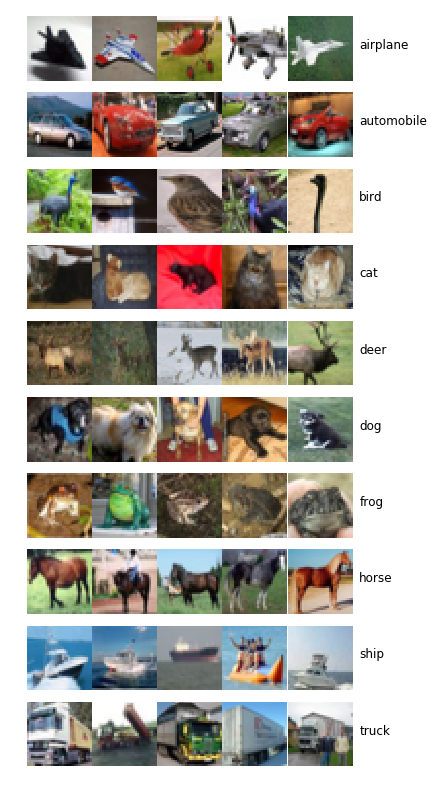

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10,6,figsize=(7,14))
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for image_type in range(10):
    # Obtain indices of images in each group
    group = np.argwhere(image_labels == image_type)
    # Display 1st 5 images from each group
    for col in range(5):
        n = group[col][0]
        img_rgb = image_data[n]
        axes[image_type,col].imshow(img_rgb)
        axes[image_type,col].axis('off')
    # Display image labels    
    axes[image_type,5].axis('off')    
    axes[image_type,5].text(0.1,0.5,label_names[image_type], fontsize=12)


plt.show()

## Model Building

In [167]:
import tensorflow as tf
# Fixed hyperparameters
height = 32
width = 32
channels = 3
outputs = 10

n_epochs = 500
# number of epochs to try to get a lower loss before stopping
early_stop_rounds = 10

# number of iterations, within epoch, to do an accuracy check
acc_check = 25

# Variable Hyperparameters
hyperparam_range = {'filters_1':[8, 16, 32, 64],
                    'ksize_1':[3, 4, 5],
                    'filters_2':[32, 48, 64, 96],
                    'ksize_2':[3, 4, 5],
                    'full_hidd_1':[60, 100, 125],
                    'full_hidd_2':[80, 100, 125],
                    'learning_rate':[0.001, 0.003, 0.01, 0.03],
                    'batch_size':[32, 64, 128, 256]}


In [168]:
def build_graph(hyperparam):
    # Retrieve hyperparamaters from dictionary   
    filters_1 = hyperparam['filters_1']
    ksize_1 = hyperparam['ksize_1']
    filters_2 = hyperparam['filters_2']
    ksize_2 = hyperparam['ksize_2']
    full_hidd_1 = hyperparam['full_hidd_1']
    full_hidd_2 = hyperparam['full_hidd_2']
    learning_rate = hyperparam['learning_rate']
    filters_1 = hyperparam['filters_1']   
    
    graph = tf.Graph()
    with graph.as_default():
        X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
        y = tf.placeholder(shape=(None), dtype=tf.int32)

        conv_1 = tf.layers.conv2d(X, filters=filters_1, kernel_size=ksize_1, strides=[2,2], padding="SAME")
        max_pool_1 = tf.nn.max_pool(conv_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
        norm_1 = tf.nn.lrn(max_pool_1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
        
        conv_2 = tf.layers.conv2d(norm_1, filters=filters_2, kernel_size=ksize_2, strides=[2,2], padding="SAME")
        max_pool_2 = tf.nn.max_pool(conv_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
        norm_2 = tf.nn.lrn(max_pool_2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)

        fully_conn_1 = tf.layers.dense(norm_2, full_hidd_1, name="fully_conn_1", activation=tf.nn.relu)
        flat = tf.contrib.layers.flatten(fully_conn_1)
        
        fully_conn_2 = tf.layers.dense(flat, full_hidd_2, name="fully_conn_2", activation=tf.nn.relu)
        logits = tf.layers.dense(fully_conn_2, outputs, name="logits")

        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(xentropy, name="loss")

        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate)
            training_op = optimizer.minimize(loss)
    
        init = tf.global_variables_initializer()
        saver = tf.train.Saver() 
        
        return graph, X, y, logits, loss, training_op, init, saver


### Model Training

In [169]:
# Function to train model, returns minimised loss
def train_model(batch_size = 128):
    training_size = image_data.shape[0]
    no_batches = training_size // batch_size

    # Add Evaluation metrics
    with graph.as_default():
        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
            acc_summary = tf.summary.scalar('Accuracy', accuracy)
            loss_summary = tf.summary.scalar('Loss', loss)

    # Initialise best loss for early stopping
    best_loss = 1e9
    best_acc = 1e9
    early_stopping = False
    
    # Run training
    with tf.Session(graph=graph) as sess:
        init.run()
        epoch = 0
        early_stop_count = 0
        # Initialise training accuracy sum
        sum_acc_train = 0
        count_acc_train = 0
        while (epoch < n_epochs) and (not early_stopping):
            epoch += 1
            for iteration in range(no_batches):
                X_batch = image_data[iteration * batch_size:(iteration + 1) * batch_size + 1]
                y_batch = image_labels[iteration * batch_size:(iteration + 1) * batch_size + 1]
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
                # Evaluate model on current mini-batch
                if (iteration % acc_check == 0):
                    acc_train, summary_str_acc_train, summary_str_loss_train = sess.run([accuracy, acc_summary, loss_summary],
                                                                                        feed_dict={X: X_batch, y: y_batch})
                    file_writer_train.add_summary(summary_str_acc_train, epoch * no_batches + iteration)
                    file_writer_train.add_summary(summary_str_loss_train, epoch * no_batches + iteration)
                    print(epoch, iteration, "Train accuracy:", acc_train, end='\r')
                    sum_acc_train += acc_train
                    count_acc_train += 1        
            # Print mean Train accuracy        
            print(epoch, iteration, "Train accuracy:", sum_acc_train / count_acc_train)        
            # Evaluate model on test data every epoch
            acc_test = accuracy.eval(feed_dict={X: test_data, y: test_labels})
            loss_test = loss.eval(feed_dict={X: test_data, y: test_labels})
            if loss_test < best_loss:
                # Reset early stopping best loss and count
                best_loss = loss_test
                best_acc = acc_test
                early_stop_count = 0
            else:
                # Increment early stopping count
                early_stop_count += 1
            if early_stop_count  > early_stop_rounds:
                early_stopping = True
                print("Early stopping, best loss: ", best_loss)
            else:    
                summary_str_acc_test = acc_summary.eval(feed_dict={X: test_data, y: test_labels})
                summary_str_loss_test = loss_summary.eval(feed_dict={X: test_data, y: test_labels})
                file_writer_test.add_summary(summary_str_acc_test, epoch * no_batches + iteration)
                file_writer_test.add_summary(summary_str_loss_test, epoch * no_batches + iteration)
                print(epoch, "Test accuracy:", acc_test, " Test loss:", loss_test)
            
        # Return Best Loss obtaned and number of epochs
        return best_loss, best_acc, epoch



In [ ]:
import pandas as pd

import random
random.seed(123)

 
import os.path
if(os.path.isfile('./log/model_hyperparam.csv')):
    hyperparam_df = pd.read_csv('./log/model_hyperparam.csv')
    new_results_file = False
else:
    new_results_file = True

# Random Model search
for n in range(20):
    # Create log directory using current timestamp
    from datetime import datetime
    now = datetime.now().strftime("%Y%m%dT%H%M%S")
    root_logdir = "./log"
    logdir = "{}/run-{}/".format(root_logdir, now)

    # Note that the graph is not written using same filewriter as the logging data.
    # This allows the logs to be viewed during training before the filewriter is closed
    file_writer_train = tf.summary.FileWriter(logdir + '/train')
    file_writer_test = tf.summary.FileWriter(logdir + 'test')

    # tensorboard --logdir e:\Programming\TensorFlow\CIFAR-10\log
    # The command must be executed from same drive (E:) as the logdir

    tf.reset_default_graph()

    hyperparam_dict = {key:random.choice(values) for (key,values) in hyperparam_range.items()}
    print("Training Model with following hyperparameters:")
    print(hyperparam_dict)

    # Obtain graph and nodes required for training
    graph, X, y, logits, loss, training_op, init, saver = build_graph(hyperparam = hyperparam_dict)

    # Train the model
    best_loss, best_acc, no_epochs = train_model(batch_size = batch_size)
    
    # Add results to dictionary
    hyperparam_dict['best_loss'] = best_loss
    hyperparam_dict['best_acc'] = best_acc
    hyperparam_dict['no_epochs'] = no_epochs
    
    # Add results to dataframe
    if new_results_file:
        hyperparam_df = pd.DataFrame(hyperparam_dict, index=[0])
        new_results_file = False
    else:
        hyperparam_df = hyperparam_df.append(hyperparam_dict, ignore_index=True)
        
    # Write results file (don't wait until end, as next model may be interrupted)
    hyperparam_df.to_csv('./log/model_hyperparam.csv', index=False)

    # Close filewriters
    file_writer_train.close()
    file_writer_test.close()

Training Model with following hyperparameters:
{'learning_rate': 0.001, 'filters_1': 32, 'batch_size': 32, 'ksize_2': 4, 'full_hidd_1': 100, 'ksize_1': 3, 'full_hidd_2': 80, 'filters_2': 96}


In [165]:
hyperparam_df = pd.read_csv('./log/model_hyperparam.csv')
hyperparam_df

,batch_size,best_acc,best_loss,filters_1,filters_2,full_hidd_1,full_hidd_2,ksize_1,ksize_2,learning_rate,no_epochs
0,32,0.4355,1.536679,32,96,100,80,3,4,0.001,1


In [156]:
hyperparam_dict
hyperparam_df.to_csv('./log/model_hyperparam.csv')

In [154]:
hyperparam_df.append(hyperparam_dict, ignore_index=True)

,Unnamed: 0,Unnamed: 0.1,batch_size,best_loss,filters_1,filters_2,full_hidd_1,full_hidd_2,ksize_1,ksize_2,learning_rate,no_epochs
0,0.0,0.0,32.0,1.583182,32.0,96.0,100.0,80.0,3.0,4.0,0.001,1.0
1,NaN,NaN,32.0,1.699057,32.0,96.0,100.0,80.0,3.0,4.0,0.001,1.0


In [158]:
hyperparam_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,batch_size,best_loss,filters_1,filters_2,full_hidd_1,full_hidd_2,ksize_1,ksize_2,learning_rate,no_epochs
0,0,0,0,32,1.583182,32,96,100,80,3,4,0.001,1
